In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tools

from IPython.display import clear_output

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Functions used:

In [3]:
def varBeta(regr, method, lmbd = 0):
    if method == 'ols':
        Bvar = np.sqrt(np.diag(regr.betaVar))
        return Bvar, regr.sigma_y
    if method == 'ridge':
        sigma = regr.sigma_y
        x = regr.symX
        W = np.linalg.inv(x+lmbd*np.eye(x.shape[0]))@x
        Bvar = np.sqrt(np.diag(sigma*W@np.linalg.inv(x)@W.T))
        
        return Bvar, sigma
    else:
        raise ValueError('method needs to be either "ols" or "ridge"')
    
def printvar(regr,Bvar,deg=5):
    mse = regr.squared_error()
    r2 = regr.r2score()
    print('MSE: ', mse)
    print('R2: ', r2)
    print('----- Conf. int.: -----')
    for i in range(len(Bvar)):
        if i in [0,5,10,15,20]:
            #print('B{:}: {:.4f} {} {:.4f}'.format(i,regr.beta[i],u'\xb1',Bvar[i]))
            #For latex
            print('$j={:}$ & {:.4f} {} {:.4f} \\'.format(i,regr.beta[i],'$\pm$',2*Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=regr.beta,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')
    
    
    return mse,r2

In [4]:
def printvar_lasso(mse,r2,Bvar,reg, deg = 5):
    betas = np.zeros((len(Bvar),))
    print('MSE: ', mse)
    print('R2: ', r2)
    print('----- Conf. int.: -----')
    for i in range(len(Bvar)):
        beta = reg.coef_[i]
        betas[i] = beta
        #print('B{:}: {:f} {} {:f}'.format(i,beta,u'\xb1',Bvar[i]))
        if i in [0,5,10,15,20]:
            #For latex
            print('$j={:}$ & {:.4f} {} {:.4f} \\'.format(i,beta,'$\pm$',2*Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=betas,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')

In [90]:
def print_scores_with_resmpl(X,z, lmbd=0, method = 'ols', smplsize=2000, deg = 5):
    if method.lower() not in ['ols','ridge','lasso']:
        raise ValueError('Invalid method flag, {}'.format(method))
    if method.lower() == 'ols' and lmbd != 0:
        raise ValueError('lmbd != 0 does not make sense for OLS.')
    if method.lower() == 'lasso':
        from sklearn.linear_model import Lasso 
    
    #mse=0
    #b_MSE_out = 0
    #b_R2_out = 0
    ## Without resampling
    if method.lower() == 'ols':
        regr = tools.Regression(X,z)
        zpred = regr.yhat
        mse = regr.squared_error()
        r2 = regr.r2score()
        out = tools.k_fold_val(x,y,z, method = 'ols', return_average=False,k=100, deg = deg)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, method = 'ols', r2_score=True, smplsize=smplsize, rep=100)
    if method.lower() == 'ridge':
        regr = tools.Regression(X,z,lmbd = lmbd)
        zpred = regr.yhat
        mse = regr.squared_error()
        r2 = regr.r2score()
        out = tools.k_fold_val(x,y,z, method = 'ridge', lmbd=lmbd, return_average=False,k=100, deg=deg)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lmbd, method = 'ridge', r2_score=True, smplsize=smplsize, rep=100)
    if method.lower() == 'lasso':
        reg = Lasso(alpha = lmbd, fit_intercept=False)
        reg.fit(X,z)
        zpred = reg.predict(X)
        mse = tools.squared_error(z,zpred)
        r2 = tools.r2score(z,zpred)
        out = tools.k_fold_val(x,y,z, method = 'lasso', lmbd=lmbd, return_average=False,k=100, deg=deg)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lmbd, method = 'lasso', r2_score=True, smplsize=smplsize, rep=100)
    
    ## With k-fold
    k_R2_in = out.T[0]
    k_MSE_in = out.T[1]
    k_R2_out = out.T[2]
    k_MSE_out = out.T[3]   
        
# REGULAR PRINT, not for latex
#     print('--------- Without resampling ---------')
#     print('MSE: ', mse)
#     print('R2: ', r2)

#     print('------- With k-fold validation -------')
#     print('MSE (in): ', k_MSE_in)
#     print('R2 (in): ', k_R2_in)
#     print('MSE (out): ', k_MSE_out)
#     print('R2 (out): ', k_R2_out)

#     ## With bootstrap
#     print('----------- With bootstrap -----------')
#     print('MSE (out): ', np.average(b_MSE_out))
#     print('R2 (out): ', np.average(b_R2_out))

    # FOR latex
    print('MSE &',round(mse,4) ,\
          '&',round(np.average(k_MSE_out),4),'$\pm$',round(np.std(k_MSE_out),4),\
          '&', round(np.average(b_MSE_out),4),'$\pm$',round(np.std(b_MSE_out),4), '\\')
    print('R2 &',round(r2,4) ,\
          '&',round(np.average(k_R2_out),4),'$\pm$',round(np.std(k_R2_out),4),\
          '&', round(np.average(b_R2_out),4),'$\pm$',round(np.std(b_R2_out),4), '\\')

# Regression analysis
Performed on the data set is the franke function for x,y$\in$[0,1], defined below with additional variables used in the regression analysis

In [60]:
from franke import FrankeFunction

N = 2000
deg = 5
x = np.random.random(size = N)
y = np.random.random(size = N)

def frankenoise(x,y,noise):
    np.random.seed(1)
    z = FrankeFunction(x,y) 
    z += np.random.normal(0,noise,size = z.size)
    return z

runs = 100
noises = np.linspace(0.0001,2,runs)
z = np.zeros((N,runs))
z = z.T

for i in range(runs):
    z[i] = frankenoise(x,y,noises[i])

X = tools.get_X_poly2D(x,y,deg=deg)

In [88]:
deg = 10 # degree of polynomial fit
N = 1000 # Data points
lambd = 0.01
noise = 0.1

x,y,z,noise = tools.generate_data(N=N, noise=noise)

X = tools.get_X_poly2D(x,y,deg=deg)

## Ordinary linear regression
Do regression and print MSE, R2 and beta with conf.int.

In [24]:
def olsBeta(X,z, errors = False):
    regr = tools.Regression(X,z,lmbd = 0)

    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method='ols')
    
    if errors == True:
        mse,r2 = printvar(regr,Bvar)
        
    return regr.beta,Bvar,sigma

### - Mean squared error and R2-score
MSE and R2 of ordinary linear regression, with and without k-fold and bootstrap

In [91]:
print_scores_with_resmpl(X,z, method = 'ols', smplsize=1000, deg=deg)

MSE & 0.0101 & 0.0119 $\pm$ 0.005 & 0.0133 $\pm$ 0.0008 \
R2 & 0.8964 & 0.8131 $\pm$ 0.1939 & 0.8425 $\pm$ 0.0139 \


In [135]:
## VAR PLoT
# plt.figure(figsize=(10,6))
# plt.subplot(2,2,1)
# plt.imshow(Bvar)
# plt.subplot(1,2,2)
# plt.errorbar(np.arange(len(Bvar)), regr.beta/regr.beta, yerr = np.sqrt(np.diag(Bvar)), fmt=".")
# plt.tight_layout()

In [136]:
# df = tools.get_exp_coeffs(Bvar)
# df.columns = ['x^{}'.format(i) for i in df.columns]
# df.index = ['y^{}'.format(i) for i in df.index]
# print(df.to_latex(na_rep='', escape = False,  column_format='lllllll'))

##### Beta coefficients and their confidence intervals

For noise =  0.01
MSE:  0.002002618377459079
R2:  0.9755821699624704
----- Conf. int.: -----
$j=0$ & 0.3463 $\pm$ 0.0349 \
$j=5$ & -34.5213 $\pm$ 1.8076 \
$j=10$ & 26.6221 $\pm$ 4.3474 \
$j=15$ & -15.9601 $\pm$ 1.7121 \
$j=20$ & 0.3997 $\pm$ 1.6632 \
For noise =  0.1
MSE:  0.011894564200208731
R2:  0.8687183146849479
----- Conf. int.: -----
$j=0$ & 0.3563 $\pm$ 0.0850 \
$j=5$ & -33.8453 $\pm$ 4.4054 \
$j=10$ & 35.6692 $\pm$ 10.5951 \
$j=15$ & -19.9073 $\pm$ 4.1726 \
$j=20$ & 0.3256 $\pm$ 4.0535 \
For noise =  1
MSE:  1.0040034696832565
R2:  0.06857448126610888
----- Conf. int.: -----
$j=0$ & 0.4564 $\pm$ 0.7807 \
$j=5$ & -27.0852 $\pm$ 40.4743 \
$j=10$ & 126.1402 $\pm$ 97.3420 \
$j=15$ & -59.3794 $\pm$ 38.3356 \
$j=20$ & -0.4154 $\pm$ 37.2408 \


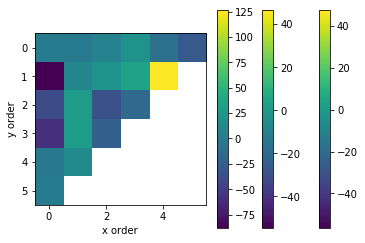

In [25]:
for i,noise in enumerate(noises):
    print('For noise = ',noise)
    olsBeta(X,z[i], errors=True)

# OLS noise dependency plot

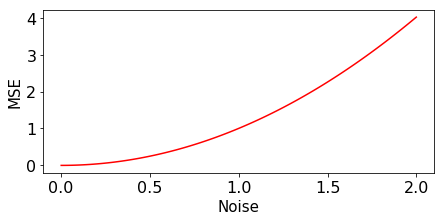

In [62]:
MSE = np.zeros(runs)
R2 = np.zeros(runs)

for i in range(runs):
    regr = tools.Regression(X,z[i],lmbd = 0)
    zpred = regr.yhat
    MSE[i] = regr.squared_error()
    R2[i] = regr.r2score()

x_ = noises
plt.figure(figsize=[7,3])
plt.rcParams.update({'font.size': 16})
#plt.subplot(211)
plt.plot(x_,MSE,'r-')
plt.xlabel('Noise',fontsize=15)
plt.ylabel('MSE',fontsize=15)
# plt.subplot(212)
# plt.plot(x_,R2,'b-')
# plt.xlabel('Noise',fontsize=15)
# plt.ylabel('R2',fontsize=15)

#plt.tight_layout()
plt.savefig('olsnoise.pdf')



# Ridge regression

In [13]:
def ridgeBeta(X,z,lambd, errors = False):
    regr = tools.Regression(X,z,lmbd = lambd)
    
    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method = 'ridge', lmbd = lambd)

    if errors == True:
        mse,r2 = printvar(regr, Bvar)
    
    return regr.beta, Bvar, sigma
    

### - Mean squared error and R2-score
MSE and R2 of ridge regression, with and without k-fold and bootstrap

In [92]:
lmbd_val = [0.000001,0.00001,0.0001,0.001,0.01,0.1]
for l,lmbd in enumerate(lmbd_val):
    print('Lambda = ',lmbd)
    print_scores_with_resmpl(X,z, lmbd=lmbd, method = 'ridge', smplsize=1000, deg= deg)
    print('')

Lambda =  1e-06
MSE & 0.0109 & 0.0119 $\pm$ 0.0047 & 0.0133 $\pm$ 0.0008 \
R2 & 0.8882 & 0.8168 $\pm$ 0.1736 & 0.8433 $\pm$ 0.0137 \

Lambda =  1e-05
MSE & 0.0113 & 0.0122 $\pm$ 0.0047 & 0.0132 $\pm$ 0.0008 \
R2 & 0.8843 & 0.8158 $\pm$ 0.1688 & 0.8427 $\pm$ 0.0141 \

Lambda =  0.0001
MSE & 0.0117 & 0.0124 $\pm$ 0.0049 & 0.0135 $\pm$ 0.0007 \
R2 & 0.8797 & 0.8129 $\pm$ 0.1689 & 0.8387 $\pm$ 0.0119 \

Lambda =  0.001
MSE & 0.0123 & 0.0129 $\pm$ 0.0053 & 0.0142 $\pm$ 0.0008 \
R2 & 0.8735 & 0.8068 $\pm$ 0.1775 & 0.8289 $\pm$ 0.0126 \

Lambda =  0.01
MSE & 0.0138 & 0.0144 $\pm$ 0.0061 & 0.016 $\pm$ 0.001 \
R2 & 0.858 & 0.7924 $\pm$ 0.1781 & 0.7983 $\pm$ 0.0148 \

Lambda =  0.1
MSE & 0.0166 & 0.0171 $\pm$ 0.0075 & 0.0193 $\pm$ 0.0012 \
R2 & 0.8291 & 0.7611 $\pm$ 0.1939 & 0.7433 $\pm$ 0.0218 \



##### Beta coefficients and their confidence intervals

MSE:  0.01176573290985534
R2:  0.8713834312375961
----- Conf. int.: -----
$j=0$ & 0.4936 $\pm$ 0.0641 \
$j=5$ & -25.6769 $\pm$ 2.9862 \
$j=10$ & 21.5112 $\pm$ 7.0289 \
$j=15$ & -12.7769 $\pm$ 2.8822 \
$j=20$ & -1.8210 $\pm$ 2.8859 \


(array([  0.49360675,   3.49062133,   5.79009654,  -9.31567918,
         -8.9352155 , -25.67688462,  -3.22501802,  11.47767941,
         30.05438917,  33.15187287,  21.51124242, -22.36653548,
          1.57954953, -38.67807395, -11.90083687, -12.77688724,
         14.5382992 ,  -8.40340494,   7.72952296,  13.32126549,
         -1.82098419]),
 array([0.03205386, 0.32579413, 0.33276242, 1.49236372, 1.24096314,
        1.49312016, 3.29291212, 2.70707882, 2.72345992, 3.27447484,
        3.51445071, 3.08879456, 2.87075178, 3.12186887, 3.49894314,
        1.4410785 , 1.51227635, 1.52871271, 1.53289481, 1.53312433,
        1.4429374 ]),
 0.011896595459914398)

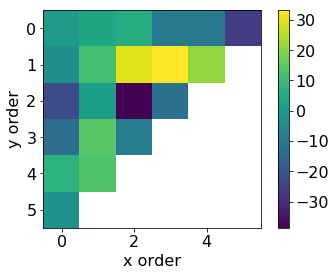

In [56]:
ridgeBeta(X,z, lambd=0.0001, errors=True)

# Noise dependency plot

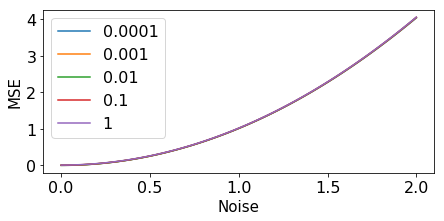

In [70]:
lmbd_runs = [0.0001,0.001,0.01,0.1,1]
MSE = np.zeros((runs,len(lmbd_runs)))
R2 = np.zeros((runs,len(lmbd_runs)))

for i in range(runs):
    for l,lambd in enumerate(lmbd_runs):
        regr = tools.Regression(X,z[i],lmbd = lambd)
        zpred = regr.yhat
        MSE[i][l] = regr.squared_error()
        R2[i][l] = regr.r2score()

        
x_ = noises
plt.figure(figsize=[7,3])
plt.rcParams.update({'font.size': 16})
#plt.subplot(211)
for j in range(len(lmbd_runs)):
    plt.plot(x_,MSE.T[:][j],'-')
plt.xlabel('Noise',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.legend(lmbd_runs)
# plt.subplot(212)
# for j in range(len(lmbd_runs)):
#     plt.plot(x_,R2.T[:][j],'-')
# plt.xlabel('Noise',fontsize=15)
# plt.ylabel('R2',fontsize=15)
# plt.legend(lmbd_runs)
# plt.tight_layout()

plt.savefig('ridgenoise.pdf')


# Lasso regression

In [40]:
from sklearn.linear_model import Lasso

def lassoBeta(X,z,lambd, errors = False):
    reg = Lasso(alpha = lambd, fit_intercept=False, max_iter=100000)
    reg.fit(X,z)
    zpred = reg.predict(X)

    mse = tools.squared_error(z,zpred)
    r2 = tools.r2score(z,zpred)
    sigma = 1/(N-deg-1) * np.sum((z-zpred)**2)
    #Bvar = np.sqrt(np.diag(np.linalg.inv(X.T@X)*sigma))
    blist = tools.k_fold_val(x,y,z, statistic_func=beta_stat, return_average=False,method='lasso',lmbd=lambd, k=10)
    _,Bvar = beta_best(blist)
    if errors == True:
        printvar_lasso(mse,r2,Bvar,reg,deg)
        
    return reg.coef_, Bvar, sigma

### - Mean squared error and R2-score
MSE and R2 of lasso regression, with and without k-fold and bootstrap

In [42]:
lmbd_val = [0.001,0.01,0.1]
for l,lmbd in enumerate(lmbd_val):
    print('Lambda = ',lmbd)
    print_scores_with_resmpl(X,z, lmbd=lmbd, method = 'lasso', smplsize=1000)
    print('')

Lambda =  0.001


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

MSE & 0.0232 & 0.0234 $\pm$ 0.0083 & 0.0234 $\pm$ 0.0008 \
R2 & 0.748 & 0.7131 $\pm$ 0.1132 & 0.6211 $\pm$ 0.0241 \

Lambda =  0.01
MSE & 0.0377 & 0.0378 $\pm$ 0.0139 & 0.0382 $\pm$ 0.0021 \
R2 & 0.5909 & 0.5586 $\pm$ 0.1043 & -0.2223 $\pm$ 0.1631 \

Lambda =  0.1


/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Document

MSE & 0.1021 & 0.1022 $\pm$ 0.0403 & 0.1017 $\pm$ 0.005 \
R2 & -0.1085 & -0.1486 $\pm$ 0.1357 & -inf $\pm$ nan \



/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Document

##### Beta coefficients and their confidence intervals
Confidence intervals not correct, using formula for OLS 

lambda =  0.001
MSE:  0.023262296665577765
R2:  0.7474981038644952
----- Conf. int.: -----
$j=0$ & 0.9932 $\pm$ 0.0136 \
$j=5$ & -0.1787 $\pm$ 0.0400 \
$j=10$ & 0.0000 $\pm$ 0.0000 \
$j=15$ & 0.6032 $\pm$ 0.0259 \
$j=20$ & -0.0000 $\pm$ 0.0000 \

lambda =  0.01
MSE:  0.03769370918273045
R2:  0.5908515320800836
----- Conf. int.: -----
$j=0$ & 0.6952 $\pm$ 0.0163 \
$j=5$ & -0.1609 $\pm$ 0.0398 \
$j=10$ & -0.0000 $\pm$ 0.0000 \
$j=15$ & -0.0000 $\pm$ 0.0000 \
$j=20$ & -0.0000 $\pm$ 0.0000 \

lambda =  0.1
MSE:  0.1021272157619525
R2:  -0.10854555754554651
----- Conf. int.: -----
$j=0$ & 0.3012 $\pm$ 0.0060 \
$j=5$ & -0.0000 $\pm$ 0.0000 \
$j=10$ & -0.0000 $\pm$ 0.0000 \
$j=15$ & -0.0000 $\pm$ 0.0000 \
$j=20$ & -0.0000 $\pm$ 0.0000 \



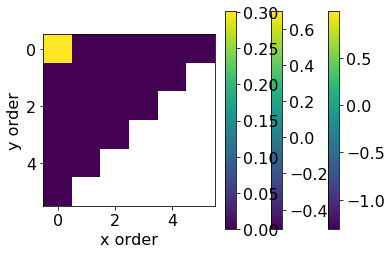

In [36]:
lmbd_val = [0.001,0.01,0.1]
for l, lmbd in enumerate(lmbd_val):    
    print('lambda = ',lmbd)
    lassoBeta(X,z,lambd=lmbd, errors=True)
    print('')

# Plot beta as a function of lambda

Run:  99


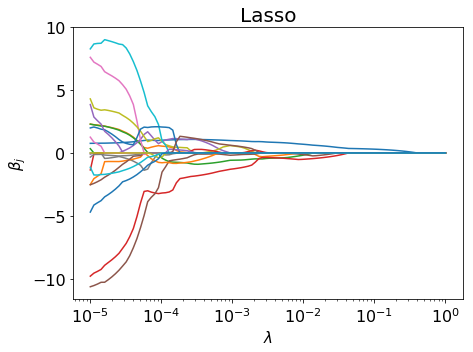

In [24]:
runs = 100
#bnum = 10

# OLS beta is not dependent of lambda, so every point is the same
#Sb,Sv,Ss = olsBeta(X,z)
#Bnum = np.argsort(np.abs(Sb))
#bnum = Bnum[0]
#print('Bnum: ',bnum)
#Sbeta = np.ones(runs)*Sb[bnum]
#Svar = np.ones(runs)*Sv[bnum]
#Ssig = np.ones(runs)*Ss

#Rbeta = np.zeros(runs)
#Rvar = np.zeros(runs)
#Rsig = np.zeros(runs)

#Rlist = np.zeros((runs,X.shape[1]))

#Lbeta = np.zeros(runs)
#Lvar = np.zeros(runs)
#Lsig = np.zeros(runs)

Lsig = np.zeros((runs,X.shape[1]))
Llist = np.zeros((runs,X.shape[1]))

#x = 100*np.log10(np.arange(runs))
x_ = np.logspace(-5, 0, runs)
#x_ = np.linspace(0, 0.4, runs)

for i, lambd in enumerate(x_):
    clear_output(wait=True)
    print('Run: ', i)
    #Rb,Rv,Rs = ridgeBeta(X,z,lambd=lambd)
    #Rbeta[i] = Rb[bnum]
    #Rvar[i] = Rv[bnum]
    #Rsig[i] = Rs
    #Rlist[i][:] = Rb
    
    #b = tools.k_fold_val(x,y,z, statistic_func=beta_stat, return_average=False,method='lasso',lmbd=lambd, k=10)
    #_,Ls = beta_best(b)
    
    Lb,Lv,Ls = lassoBeta(X,z,lambd=lambd)
    #Lbeta[i] = Lb[bnum]
    #Lvar[i] = Lv[bnum]
    #Lsig[i][:] = Ls
    Llist[i][:] = Lb

# #OLS
# plt.plot(x,Sbeta, 'r-')
# plt.fill_between(x,Sbeta+Ssig,Sbeta-Ssig,alpha=0.1,color='r')
# #Ridge
# plt.plot(x,Rbeta, 'b-')
# plt.fill_between(x,Rbeta+Rsig,Rbeta-Rsig,alpha=0.1,color='b')
# #Lasso
# plt.plot(x,Lbeta, 'g-')
# plt.fill_between(x,Lbeta+Lsig,Lbeta-Lsig,alpha=0.1,color='g')

plt.rcParams.update({'font.size': 16})
# figridge = plt.figure(figsize=[7,5])
# #plt.subplot(121)
# for i in range(X.shape[1]):
#     plt.semilogx(x_,Rlist.T[i])#,'b-')
#     plt.fill_between(x_,Rlist.T[i]+Rsig,Rlist.T[i]-Rsig,alpha=0.1)#,color='b')
# plt.xlabel(r'$ \lambda $',fontsize=15)
# plt.ylabel(r'$ \beta_j $',fontsize=15)
# plt.title('Ridge',fontsize=20)
# #plt.legend(['B_{}'.format(i) for i in range(X.shape[1])])
# plt.savefig('betaRidge.pdf')

#print(Llist.T[2])
#print(Lsig.T[2])

figlasso = plt.figure(figsize=[7,5])
for i in range(X.shape[1]):
    plt.semilogx(x_,Llist.T[i])#,'g-')
    plt.fill_between(x_,Llist.T[i]+Lsig.T[i],Llist.T[i]-Lsig.T[i],alpha=0.1)#,color='g')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Lasso',fontsize=20)
plt.savefig('betaLasso.pdf')

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


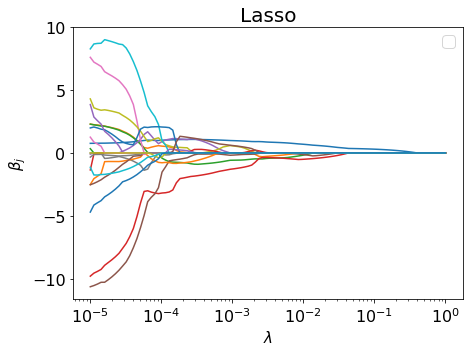

In [32]:
figlasso = plt.figure(figsize=[7,5])
for i in range(X.shape[1]):
    plt.semilogx(x_,Llist.T[i])#,'g-')
    plt.fill_between(x_,Llist.T[i]+Lsig.T[i],Llist.T[i]-Lsig.T[i],alpha=0.1)#,color='g')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Lasso',fontsize=20)
plt.legend()
plt.savefig('betaLasso.pdf')

plt.show()

In [7]:
def beta_stat(regr,*args):
    return regr.coef_

def beta_best(betalist):
    n = betalist.shape[1]
    std = np.zeros(n)
    best = np.zeros(n)
    for i in range(n):
        betas = betalist.T[i]
        best[i] = np.mean(betas)
        std[i] = np.std(betas)
    return best,std

In [183]:
b = tools.k_fold_val(x,y,z, statistic_func=beta_stat, return_average=False,method='lasso',lmbd=lambd, k=10)
be,s = beta_best(b)
print(be)
print(s)

q,w,e = lassoBeta(X,z,lambd = lambd, errors=False)
print(q)


[ 0.70289787  0.         -0.18324824 -0.4939158   0.         -0.15255257
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[0.00695038 0.         0.02122864 0.00457467 0.         0.01844904
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
[ 0.7029158  -0.         -0.18328536 -0.49398098 -0.         -0.15250024
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]


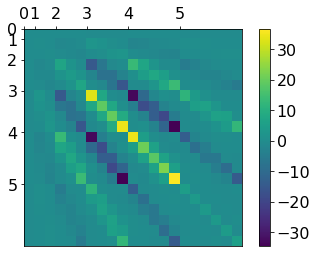

In [393]:
import plotting
regr = tools.Regression(X,z,lmbd = 0.01)
zpred = regr.yhat

plotting.plot_covar(deg=5,regr=regr, save_plot=True)

#cl = plt.imshow(regr.betaVar)
#plt.colorbar(cl)

# LASSO noise dependency plot

yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes

/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


yes
yes


/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


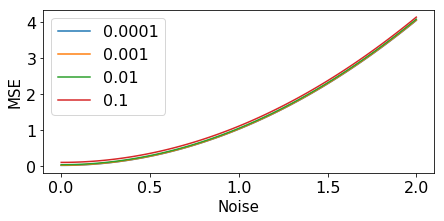

In [65]:
from sklearn.linear_model import Lasso

lmbd_runs = [0.0001,0.001,0.01,0.1]
MSE = np.zeros((runs,len(lmbd_runs)))
R2 = np.zeros((runs,len(lmbd_runs)))
for i in range(runs):
    print('yes')
    for l,lambd in enumerate(lmbd_runs):
        reg = Lasso(alpha = lambd, fit_intercept=False)
        reg.fit(X,z[i])
        zpred = reg.predict(X)

        MSE[i][l] = tools.squared_error(z[i],zpred)
        R2[i][l] = tools.r2score(z[i],zpred)

        
x_ = noises
plt.figure(figsize=[7,3])
plt.rcParams.update({'font.size': 16})
#plt.subplot(211)
for j in range(len(lmbd_runs)):
    plt.plot(x_,MSE.T[:][j],'-')
plt.xlabel('Noise',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.legend(lmbd_runs)
# plt.subplot(212)
# for j in range(len(lmbd_runs)):
#     plt.plot(x_,R2.T[:][j],'-')
# plt.xlabel('Noise',fontsize=15)
# plt.ylabel('R2',fontsize=15)
# plt.legend(lmbd_runs)
#plt.tight_layout()

plt.savefig('lassonoise.pdf')

